# 1. Import libraries and dataset

In [ ]:
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, f1_score, classification_report

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data pre-processing

In [ ]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
def preprocessing(dataset):
  
  dataset['sex'] = dataset['Sex'].apply(lambda x: 1 if x == 'male' else 0).astype('int')
  dataset['embark'] = dataset['Embarked'].apply(lambda x: 0 if x =='S' else(1 if x == 'C' else '2')).astype('int')

  for n in ['Name', 'Cabin', 'Ticket', 'Sex', 'Embarked']:
    dataset.drop(n, axis=1, inplace = True)

  return dataset

In [ ]:
train = preprocessing(train)
test = preprocessing(test)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   sex          891 non-null    int64  
 8   embark       891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 62.8 KB


In [ ]:
train.head(5)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,sex,embark
0,1,0,3,22.0,1,0,7.2500,1,0
1,2,1,1,38.0,1,0,71.2833,0,1
2,3,1,3,26.0,0,0,7.9250,0,0
3,4,1,1,35.0,1,0,53.1000,0,0
4,5,0,3,35.0,0,0,8.0500,1,0


In [ ]:
yData = train.pop('Survived').to_numpy()
xData = train.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(xData, yData, test_size = .2, 
                                                    stratify=yData, shuffle=True, random_state = 42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((712, 8), (712,), (179, 8), (179,))

# XGBoost

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500, 800], 
    'learning_rate': [0.001, 0.01, 0.1, 0.3]
    }

xgb = XGBClassifier()
xgb_grid = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', verbose = 3)
xgb_grid.fit(x_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END learning_rate=0.001, n_estimators=100;, score=0.803 total time=   0.2s
[CV 2/3] END learning_rate=0.001, n_estimators=100;, score=0.802 total time=   0.1s
[CV 3/3] END learning_rate=0.001, n_estimators=100;, score=0.827 total time=   0.1s
[CV 1/3] END learning_rate=0.001, n_estimators=200;, score=0.803 total time=   0.1s
[CV 2/3] END learning_rate=0.001, n_estimators=200;, score=0.810 total time=   0.1s
[CV 3/3] END learning_rate=0.001, n_estimators=200;, score=0.827 total time=   0.1s
[CV 1/3] END learning_rate=0.001, n_estimators=500;, score=0.803 total time=   0.3s
[CV 2/3] END learning_rate=0.001, n_estimators=500;, score=0.814 total time=   0.3s
[CV 3/3] END learning_rate=0.001, n_estimators=500;, score=0.827 total time=   0.4s
[CV 1/3] END learning_rate=0.001, n_estimators=800;, score=0.803 total time=   0.5s
[CV 2/3] END learning_rate=0.001, n_estimators=800;, score=0.814 total time=   0.5s
[CV 3/3] END le

GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.3],
                         'n_estimators': [100, 200, 500, 800]},
             scoring='accuracy', verbose=3)

In [ ]:
print(xgb_grid.best_params_)

{'learning_rate': 0.01, 'n_estimators': 200}


In [ ]:
final_xgb = XGBClassifier(learning_rate=0.01, n_estimators=200)
eval_set = [(x_train, y_train), (x_test, y_test)]
final_xgb.fit(x_train, y_train, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
final_xgb_label_pred = final_xgb.predict(x_test)

[0]	validation_0-error:0.168539	validation_0-logloss:0.688312	validation_1-error:0.217877	validation_1-logloss:0.689198
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.168539	validation_0-logloss:0.683572	validation_1-error:0.217877	validation_1-logloss:0.685208
[2]	validation_0-error:0.168539	validation_0-logloss:0.67892	validation_1-error:0.217877	validation_1-logloss:0.681302
[3]	validation_0-error:0.168539	validation_0-logloss:0.674356	validation_1-error:0.217877	validation_1-logloss:0.677476
[4]	validation_0-error:0.168539	validation_0-logloss:0.669882	validation_1-error:0.217877	validation_1-logloss:0.673729
[5]	validation_0-error:0.168539	validation_0-logloss:0.665488	validation_1-error:0.217877	validation_1-logloss:0.670057
[6]	validation_0-error:0.168539	validation_0-logloss:0.66118	validation_1-error:0.217877	validation_1-logloss:0.6663

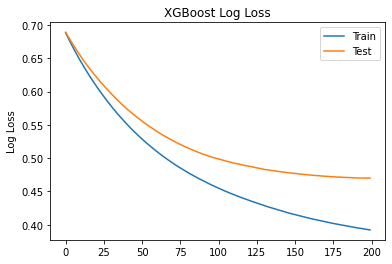

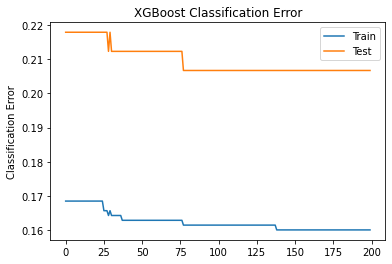

In [ ]:
results = final_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
xgb_acc = accuracy_score(y_test, final_xgb_label_pred)
print("Accuracy for XGBoost on test set: {:.3f}".format(xgb_acc))

print(f"Classification report for classifier XGBoost:\n"
      f"{classification_report(y_test, final_xgb_label_pred)}")

Accuracy for XGBoost on test set: 0.793
Classification report for classifier XGBoost:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       110
           1       0.83      0.58      0.68        69

    accuracy                           0.79       179
   macro avg       0.81      0.75      0.77       179
weighted avg       0.80      0.79      0.78       179



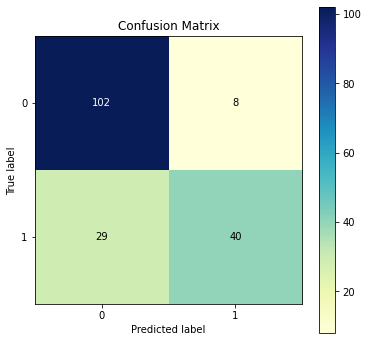

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, final_xgb_label_pred, figsize=(6,6), cmap= 'YlGnBu');

# Output

In [ ]:
test['Survived'] = final_xgb.predict(test.values)
submission = test[['PassengerId','Survived']]
submission.to_csv("submission.csv", index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
